In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
import cv2
import plotly.express as px
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
import plotly.express as px
import plotly.graph_objects as go

from google.colab import files #library to upload files to colab notebook
%matplotlib inline

In [2]:
# Mount the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
sales_df = pd.read_csv('/content/drive/My Drive/Datasets/sales_data_sample.csv', encoding = 'unicode_escape')

In [4]:
sales_df

,ORDERNUMBER,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,STATUS,QTR_ID,MONTH_ID,YEAR_ID,...,ADDRESSLINE1,ADDRESSLINE2,CITY,STATE,POSTALCODE,COUNTRY,TERRITORY,CONTACTLASTNAME,CONTACTFIRSTNAME,DEALSIZE
0,10107,30,95.70,2,2871.00,2/24/2003 0:00,Shipped,1,2,2003,...,897 Long Airport Avenue,NaN,NYC,NY,10022,USA,NaN,Yu,Kwai,Small
1,10121,34,81.35,5,2765.90,5/7/2003 0:00,Shipped,2,5,2003,...,59 rue de l'Abbaye,NaN,Reims,NaN,51100,France,EMEA,Henriot,Paul,Small
2,10134,41,94.74,2,3884.34,7/1/2003 0:00,Shipped,3,7,2003,...,27 rue du Colonel Pierre Avia,NaN,Paris,NaN,75508,France,EMEA,Da Cunha,Daniel,Medium
3,10145,45,83.26,6,3746.70,8/25/2003 0:00,Shipped,3,8,2003,...,78934 Hillside Dr.,NaN,Pasadena,CA,90003,USA,NaN,Young,Julie,Medium
4,10159,49,100.00,14,5205.27,10/10/2003 0:00,Shipped,4,10,2003,...,7734 Strong St.,NaN,San Francisco,CA,NaN,USA,NaN,Brown,Julie,Medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2818,10350,20,100.00,15,2244.40,12/2/2004 0:00,Shipped,4,12,2004,...,"C/ Moralzarzal, 86",NaN,Madrid,NaN,28034,Spain,EMEA,Freyre,Diego,Small
2819,10373,29,100.00,1,3978.51,1/31/2005 0:00,Shipped,1,1,2005,...,Torikatu 38,NaN,Oulu,NaN,90110,Finland,EMEA,Koskitalo,Pirkko,Medium
2820,10386,43,100.00,4,5417.57,3/1/2005 0:00,Resolved,1,3,2005,...,"C/ Moralzarzal, 86",NaN,Madrid,NaN,28034,Spain,EMEA,Freyre,Diego,Medium
2821,10397,34,62.24,1,2116.16,3/28/2005 0:00,Shipped,1,3,2005,...,1 rue Alsace-Lorraine,NaN,Toulouse,NaN,31000,France,EMEA,Roulet,Annette,Small


In [5]:
#view the types of data
sales_df.dtypes

ORDERNUMBER           int64
QUANTITYORDERED       int64
PRICEEACH           float64
ORDERLINENUMBER       int64
SALES               float64
ORDERDATE            object
STATUS               object
QTR_ID                int64
MONTH_ID              int64
YEAR_ID               int64
PRODUCTLINE          object
MSRP                  int64
PRODUCTCODE          object
CUSTOMERNAME         object
PHONE                object
ADDRESSLINE1         object
ADDRESSLINE2         object
CITY                 object
STATE                object
POSTALCODE           object
COUNTRY              object
TERRITORY            object
CONTACTLASTNAME      object
CONTACTFIRSTNAME     object
DEALSIZE             object
dtype: object

In [6]:
# Converting order date to datetime format
sales_df['ORDERDATE'] = pd.to_datetime(sales_df['ORDERDATE'])
# Check the type of data
sales_df.dtypes

ORDERNUMBER                  int64
QUANTITYORDERED              int64
PRICEEACH                  float64
ORDERLINENUMBER              int64
SALES                      float64
ORDERDATE           datetime64[ns]
STATUS                      object
QTR_ID                       int64
MONTH_ID                     int64
YEAR_ID                      int64
PRODUCTLINE                 object
MSRP                         int64
PRODUCTCODE                 object
CUSTOMERNAME                object
PHONE                       object
ADDRESSLINE1                object
ADDRESSLINE2                object
CITY                        object
STATE                       object
POSTALCODE                  object
COUNTRY                     object
TERRITORY                   object
CONTACTLASTNAME             object
CONTACTFIRSTNAME            object
DEALSIZE                    object
dtype: object

In [7]:
# Checking the number of non-null values in the dataframe
sales_df.info()

# Checking the number of Null values in the data
sales_df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2823 entries, 0 to 2822
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   ORDERNUMBER       2823 non-null   int64         
 1   QUANTITYORDERED   2823 non-null   int64         
 2   PRICEEACH         2823 non-null   float64       
 3   ORDERLINENUMBER   2823 non-null   int64         
 4   SALES             2823 non-null   float64       
 5   ORDERDATE         2823 non-null   datetime64[ns]
 6   STATUS            2823 non-null   object        
 7   QTR_ID            2823 non-null   int64         
 8   MONTH_ID          2823 non-null   int64         
 9   YEAR_ID           2823 non-null   int64         
 10  PRODUCTLINE       2823 non-null   object        
 11  MSRP              2823 non-null   int64         
 12  PRODUCTCODE       2823 non-null   object        
 13  CUSTOMERNAME      2823 non-null   object        
 14  PHONE             2823 n

ORDERNUMBER            0
QUANTITYORDERED        0
PRICEEACH              0
ORDERLINENUMBER        0
SALES                  0
ORDERDATE              0
STATUS                 0
QTR_ID                 0
MONTH_ID               0
YEAR_ID                0
PRODUCTLINE            0
MSRP                   0
PRODUCTCODE            0
CUSTOMERNAME           0
PHONE                  0
ADDRESSLINE1           0
ADDRESSLINE2        2521
CITY                   0
STATE               1486
POSTALCODE            76
COUNTRY                0
TERRITORY           1074
CONTACTLASTNAME        0
CONTACTFIRSTNAME       0
DEALSIZE               0
dtype: int64

In [8]:
# since there are lot of Null values in 'addressline2', 'state', 'postal code' and 'territory' we can drop them.
# Country would represent the order grographical information.
# Also we can drop city, address1, phone number, contact_name, contact last_name and contact first_name since they are not required for the analysis

df_drop  = ['ADDRESSLINE1', 'ADDRESSLINE2', 'POSTALCODE', 'CITY', 'TERRITORY', 'PHONE', 'STATE', 'CONTACTFIRSTNAME', 'CONTACTLASTNAME', 'CUSTOMERNAME', 'ORDERNUMBER']
sales_df = sales_df.drop(df_drop, axis = 1)
sales_df.head()

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,STATUS,QTR_ID,MONTH_ID,YEAR_ID,PRODUCTLINE,MSRP,PRODUCTCODE,COUNTRY,DEALSIZE
0,30,95.70,2,2871.00,2003-02-24,Shipped,1,2,2003,Motorcycles,95,S10_1678,USA,Small
1,34,81.35,5,2765.90,2003-05-07,Shipped,2,5,2003,Motorcycles,95,S10_1678,France,Small
2,41,94.74,2,3884.34,2003-07-01,Shipped,3,7,2003,Motorcycles,95,S10_1678,France,Medium
3,45,83.26,6,3746.70,2003-08-25,Shipped,3,8,2003,Motorcycles,95,S10_1678,USA,Medium
4,49,100.00,14,5205.27,2003-10-10,Shipped,4,10,2003,Motorcycles,95,S10_1678,USA,Medium


In [9]:
sales_df.isnull().sum()

QUANTITYORDERED    0
PRICEEACH          0
ORDERLINENUMBER    0
SALES              0
ORDERDATE          0
STATUS             0
QTR_ID             0
MONTH_ID           0
YEAR_ID            0
PRODUCTLINE        0
MSRP               0
PRODUCTCODE        0
COUNTRY            0
DEALSIZE           0
dtype: int64

In [10]:
# Obtaining the number of unique values in each column
sales_df.nunique()

QUANTITYORDERED      58
PRICEEACH          1016
ORDERLINENUMBER      18
SALES              2763
ORDERDATE           252
STATUS                6
QTR_ID                4
MONTH_ID             12
YEAR_ID               3
PRODUCTLINE           7
MSRP                 80
PRODUCTCODE         109
COUNTRY              19
DEALSIZE              3
dtype: int64

In [11]:
sales_df['COUNTRY'].value_counts().index

Index(['USA', 'Spain', 'France', 'Australia', 'UK', 'Italy', 'Finland',
       'Norway', 'Singapore', 'Canada', 'Denmark', 'Germany', 'Sweden',
       'Austria', 'Japan', 'Belgium', 'Switzerland', 'Philippines', 'Ireland'],
      dtype='object')

In [12]:
sales_df['COUNTRY'].value_counts()

USA            1004
Spain           342
France          314
Australia       185
UK              144
Italy           113
Finland          92
Norway           85
Singapore        79
Canada           70
Denmark          63
Germany          62
Sweden           57
Austria          55
Japan            52
Belgium          33
Switzerland      31
Philippines      26
Ireland          16
Name: COUNTRY, dtype: int64

In [13]:
# Function to visulize the count of items in a given column
def barplot_visualization(x):
  fig = plt.Figure(figsize = (12, 6))
  fig = px.bar(x = sales_df[x].value_counts().index, y = sales_df[x].value_counts(), color = sales_df[x].value_counts().index, height = 600)
  fig.show()

In [14]:
# Let's call this function for any given column such as 'COUNTRY'
barplot_visualization('COUNTRY')

In [15]:
barplot_visualization('STATUS')

In [16]:
sales_df.drop(columns= ['STATUS'], inplace = True)
sales_df

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,QTR_ID,MONTH_ID,YEAR_ID,PRODUCTLINE,MSRP,PRODUCTCODE,COUNTRY,DEALSIZE
0,30,95.70,2,2871.00,2003-02-24,1,2,2003,Motorcycles,95,S10_1678,USA,Small
1,34,81.35,5,2765.90,2003-05-07,2,5,2003,Motorcycles,95,S10_1678,France,Small
2,41,94.74,2,3884.34,2003-07-01,3,7,2003,Motorcycles,95,S10_1678,France,Medium
3,45,83.26,6,3746.70,2003-08-25,3,8,2003,Motorcycles,95,S10_1678,USA,Medium
4,49,100.00,14,5205.27,2003-10-10,4,10,2003,Motorcycles,95,S10_1678,USA,Medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2818,20,100.00,15,2244.40,2004-12-02,4,12,2004,Ships,54,S72_3212,Spain,Small
2819,29,100.00,1,3978.51,2005-01-31,1,1,2005,Ships,54,S72_3212,Finland,Medium
2820,43,100.00,4,5417.57,2005-03-01,1,3,2005,Ships,54,S72_3212,Spain,Medium
2821,34,62.24,1,2116.16,2005-03-28,1,3,2005,Ships,54,S72_3212,France,Small


In [17]:
barplot_visualization('PRODUCTLINE')

In [18]:
barplot_visualization('DEALSIZE')

In [19]:
# Function to add dummy variables to replace categorical variables

def dummies(x):
  dummy = pd.get_dummies(sales_df[x])
  sales_df.drop(columns = x , inplace = True)
  return pd.concat([sales_df, dummy], axis = 1)

In [20]:
# Let's obtain dummy variables for the column 'COUNTRY'
sales_df = dummies('COUNTRY')
sales_df

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,QTR_ID,MONTH_ID,YEAR_ID,PRODUCTLINE,MSRP,...,Italy,Japan,Norway,Philippines,Singapore,Spain,Sweden,Switzerland,UK,USA
0,30,95.70,2,2871.00,2003-02-24,1,2,2003,Motorcycles,95,...,0,0,0,0,0,0,0,0,0,1
1,34,81.35,5,2765.90,2003-05-07,2,5,2003,Motorcycles,95,...,0,0,0,0,0,0,0,0,0,0
2,41,94.74,2,3884.34,2003-07-01,3,7,2003,Motorcycles,95,...,0,0,0,0,0,0,0,0,0,0
3,45,83.26,6,3746.70,2003-08-25,3,8,2003,Motorcycles,95,...,0,0,0,0,0,0,0,0,0,1
4,49,100.00,14,5205.27,2003-10-10,4,10,2003,Motorcycles,95,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2818,20,100.00,15,2244.40,2004-12-02,4,12,2004,Ships,54,...,0,0,0,0,0,1,0,0,0,0
2819,29,100.00,1,3978.51,2005-01-31,1,1,2005,Ships,54,...,0,0,0,0,0,0,0,0,0,0
2820,43,100.00,4,5417.57,2005-03-01,1,3,2005,Ships,54,...,0,0,0,0,0,1,0,0,0,0
2821,34,62.24,1,2116.16,2005-03-28,1,3,2005,Ships,54,...,0,0,0,0,0,0,0,0,0,0


In [21]:
sales_df = dummies('PRODUCTLINE')

In [22]:
sales_df

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,QTR_ID,MONTH_ID,YEAR_ID,MSRP,PRODUCTCODE,...,Switzerland,UK,USA,Classic Cars,Motorcycles,Planes,Ships,Trains,Trucks and Buses,Vintage Cars
0,30,95.70,2,2871.00,2003-02-24,1,2,2003,95,S10_1678,...,0,0,1,0,1,0,0,0,0,0
1,34,81.35,5,2765.90,2003-05-07,2,5,2003,95,S10_1678,...,0,0,0,0,1,0,0,0,0,0
2,41,94.74,2,3884.34,2003-07-01,3,7,2003,95,S10_1678,...,0,0,0,0,1,0,0,0,0,0
3,45,83.26,6,3746.70,2003-08-25,3,8,2003,95,S10_1678,...,0,0,1,0,1,0,0,0,0,0
4,49,100.00,14,5205.27,2003-10-10,4,10,2003,95,S10_1678,...,0,0,1,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2818,20,100.00,15,2244.40,2004-12-02,4,12,2004,54,S72_3212,...,0,0,0,0,0,0,1,0,0,0
2819,29,100.00,1,3978.51,2005-01-31,1,1,2005,54,S72_3212,...,0,0,0,0,0,0,1,0,0,0
2820,43,100.00,4,5417.57,2005-03-01,1,3,2005,54,S72_3212,...,0,0,0,0,0,0,1,0,0,0
2821,34,62.24,1,2116.16,2005-03-28,1,3,2005,54,S72_3212,...,0,0,0,0,0,0,1,0,0,0


In [23]:
sales_df = dummies('DEALSIZE')
sales_df

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,QTR_ID,MONTH_ID,YEAR_ID,MSRP,PRODUCTCODE,...,Classic Cars,Motorcycles,Planes,Ships,Trains,Trucks and Buses,Vintage Cars,Large,Medium,Small
0,30,95.70,2,2871.00,2003-02-24,1,2,2003,95,S10_1678,...,0,1,0,0,0,0,0,0,0,1
1,34,81.35,5,2765.90,2003-05-07,2,5,2003,95,S10_1678,...,0,1,0,0,0,0,0,0,0,1
2,41,94.74,2,3884.34,2003-07-01,3,7,2003,95,S10_1678,...,0,1,0,0,0,0,0,0,1,0
3,45,83.26,6,3746.70,2003-08-25,3,8,2003,95,S10_1678,...,0,1,0,0,0,0,0,0,1,0
4,49,100.00,14,5205.27,2003-10-10,4,10,2003,95,S10_1678,...,0,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2818,20,100.00,15,2244.40,2004-12-02,4,12,2004,54,S72_3212,...,0,0,0,1,0,0,0,0,0,1
2819,29,100.00,1,3978.51,2005-01-31,1,1,2005,54,S72_3212,...,0,0,0,1,0,0,0,0,1,0
2820,43,100.00,4,5417.57,2005-03-01,1,3,2005,54,S72_3212,...,0,0,0,1,0,0,0,0,1,0
2821,34,62.24,1,2116.16,2005-03-28,1,3,2005,54,S72_3212,...,0,0,0,1,0,0,0,0,0,1


In [24]:
y = pd.Categorical(sales_df['PRODUCTCODE'])
y

['S10_1678', 'S10_1678', 'S10_1678', 'S10_1678', 'S10_1678', ..., 'S72_3212', 'S72_3212', 'S72_3212', 'S72_3212', 'S72_3212']
Length: 2823
Categories (109, object): ['S10_1678', 'S10_1949', 'S10_2016', 'S10_4698', ..., 'S700_3962',
                           'S700_4002', 'S72_1253', 'S72_3212']

In [25]:
y = pd.Categorical(sales_df['PRODUCTCODE']).codes
y

array([  0,   0,   0, ..., 108, 108, 108], dtype=int8)

In [26]:
sales_df['PRODUCTCODE'] = y

In [27]:
sales_df

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,QTR_ID,MONTH_ID,YEAR_ID,MSRP,PRODUCTCODE,...,Classic Cars,Motorcycles,Planes,Ships,Trains,Trucks and Buses,Vintage Cars,Large,Medium,Small
0,30,95.70,2,2871.00,2003-02-24,1,2,2003,95,0,...,0,1,0,0,0,0,0,0,0,1
1,34,81.35,5,2765.90,2003-05-07,2,5,2003,95,0,...,0,1,0,0,0,0,0,0,0,1
2,41,94.74,2,3884.34,2003-07-01,3,7,2003,95,0,...,0,1,0,0,0,0,0,0,1,0
3,45,83.26,6,3746.70,2003-08-25,3,8,2003,95,0,...,0,1,0,0,0,0,0,0,1,0
4,49,100.00,14,5205.27,2003-10-10,4,10,2003,95,0,...,0,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2818,20,100.00,15,2244.40,2004-12-02,4,12,2004,54,108,...,0,0,0,1,0,0,0,0,0,1
2819,29,100.00,1,3978.51,2005-01-31,1,1,2005,54,108,...,0,0,0,1,0,0,0,0,1,0
2820,43,100.00,4,5417.57,2005-03-01,1,3,2005,54,108,...,0,0,0,1,0,0,0,0,1,0
2821,34,62.24,1,2116.16,2005-03-28,1,3,2005,54,108,...,0,0,0,1,0,0,0,0,0,1


In [28]:
# Group data by order date
sales_df_group = sales_df.groupby(by = "ORDERDATE").sum()
sales_df_group

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,QTR_ID,MONTH_ID,YEAR_ID,MSRP,PRODUCTCODE,Australia,...,Classic Cars,Motorcycles,Planes,Ships,Trains,Trucks and Buses,Vintage Cars,Large,Medium,Small
ORDERDATE,,,,,,,,,,,,,,,,,,,,,
2003-01-06,151,288.78,10,12133.25,4,4,8012,363,174,0,...,0,0,0,0,0,0,4,0,2,2
2003-01-09,142,284.96,10,11432.34,4,4,8012,372,181,0,...,0,0,0,0,0,0,4,0,2,2
2003-01-10,80,150.14,3,6864.05,2,2,4006,155,37,0,...,0,0,0,0,0,0,2,0,1,1
2003-01-29,541,1417.54,136,54702.00,16,16,32048,1695,723,0,...,3,0,0,0,0,7,6,0,10,6
2003-01-31,443,1061.89,91,44621.96,13,13,26039,1365,720,0,...,7,0,0,0,2,4,0,0,8,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2005-05-13,259,561.18,21,31821.90,12,30,12030,728,101,0,...,0,6,0,0,0,0,0,2,3,1
2005-05-17,509,1269.43,105,59475.10,28,70,28070,1669,462,0,...,14,0,0,0,0,0,0,2,8,4
2005-05-29,607,1148.40,94,51233.18,30,75,30075,1328,797,13,...,7,0,0,0,0,0,8,0,8,7


In [29]:
#When did the sale peaked
fig = px.line(x = sales_df_group.index, y = sales_df_group.SALES, title = 'Sales')
fig.show()

In [30]:
# We can drop 'ORDERDATE' and keep the rest of the date-related data such as 'MONTH' since they contain same data
sales_df.drop("ORDERDATE", axis = 1, inplace = True)
sales_df.shape

(2823, 38)

<Axes: >

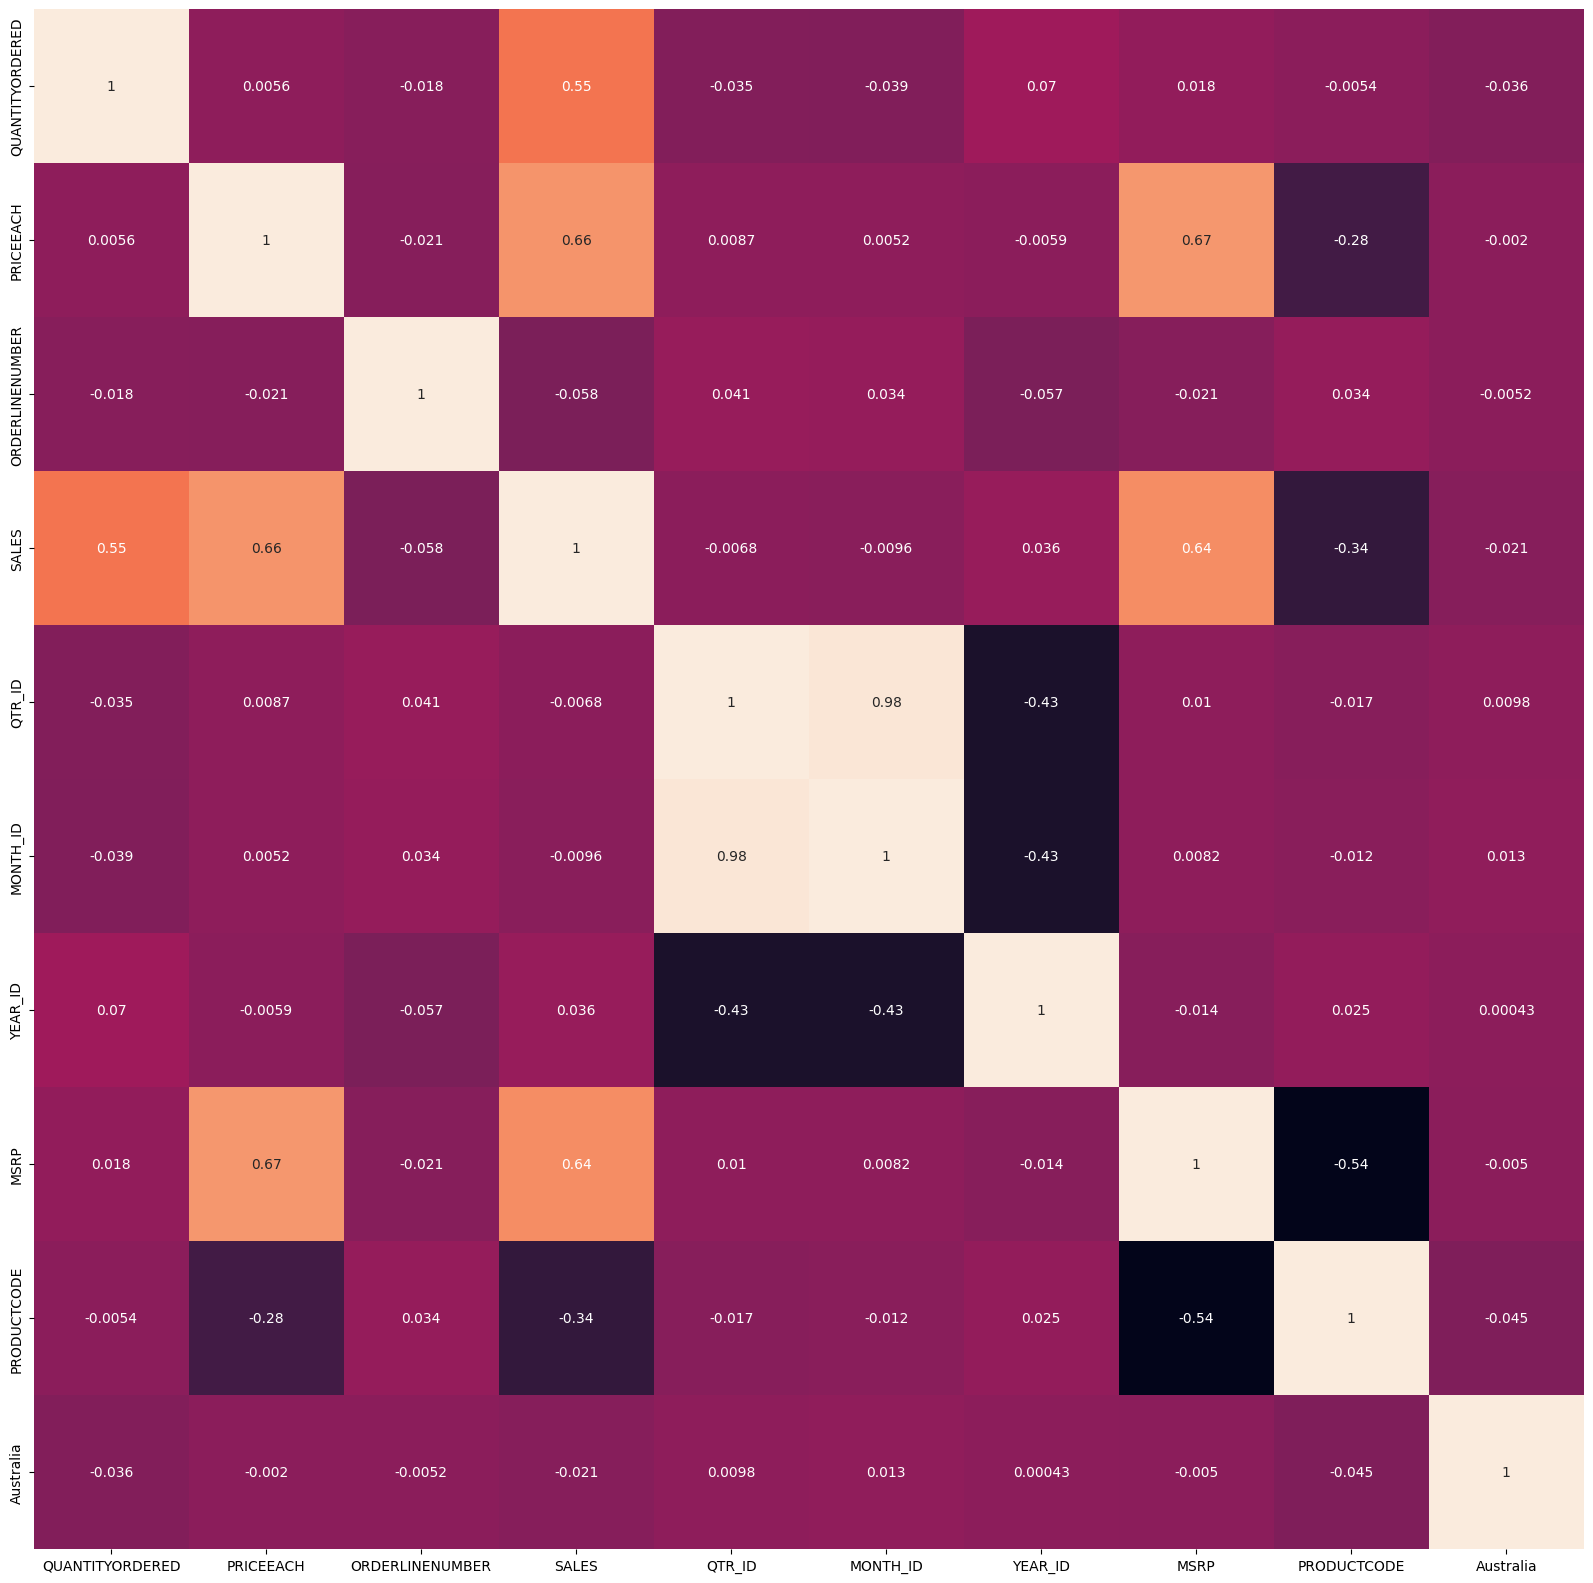

In [31]:
plt.figure(figsize = (20, 20))
corr_matrix = sales_df.iloc[:, :10].corr()
sns.heatmap(corr_matrix, annot = True, cbar = False)

In [32]:
# the Quarter ID and the monthly IDs are highly correlated
# Let's drop 'QTR_ID' (or 'MONTH_ID')
sales_df.drop("QTR_ID", axis = 1, inplace = True)
sales_df.shape

(2823, 37)

In [33]:
# Let's plot distplots
# Distplot shows the (1) histogram, (2) kde plot and (3) rug plot.
# (1) Histogram: it's a graphical display of data using bars with various heights. Each bar groups numbers into ranges and taller bars show that more data falls in that range.
# (2) Kde Plot: Kernel Density Estimate is used for visualizing the Probability Density of a continuous variable.
# (3) Rug plot: plot of data for a single quantitative variable, displayed as marks along an axis (one-dimensional scatter plot).

import plotly.figure_factory as ff

plt.figure(figsize = (10, 10))

for i in range(8):
  if sales_df.columns[i] != 'ORDERLINENUMBER':
    fig = ff.create_distplot([sales_df[sales_df.columns[i]].apply(lambda x: float(x))], ['distplot'])
    fig.update_layout(title_text = sales_df.columns[i])
    fig.show()


<Figure size 1000x1000 with 0 Axes>

In [34]:
# Visualize the relationship between variables using pairplots
plt.figure(figsize = (15, 15))

fig = px.scatter_matrix(sales_df,
    dimensions = sales_df.columns[:8], color = 'MONTH_ID')

fig.update_layout(
    title = 'Sales Data',
    width = 1100,
    height = 1100,
)
fig.show()

# A trend exists between 'SALES' and 'QUANTITYORDERED'
# A trend exists between 'MSRP' and 'PRICEEACH'
# A trend exists between 'PRICEEACH' and 'SALES'
# It seems that sales growth exists as we move from 2013 to 2014 to 2015 ('SALES' vs. 'YEAR_ID')
# zoom in into 'SALES' and 'QUANTITYORDERED', you will be able to see the monthly information color coded on the graph


<Figure size 1500x1500 with 0 Axes>

In [35]:
# Scale the data
scaler = StandardScaler()
sales_df_scaled = scaler.fit_transform(sales_df)

In [36]:
sales_df_scaled.shape

(2823, 37)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will chang

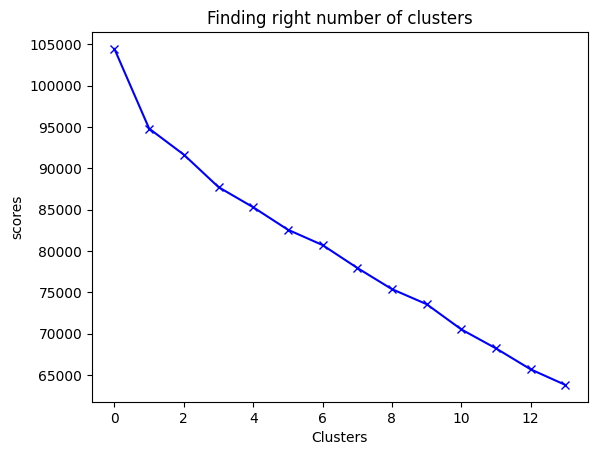

In [37]:
scores = []

range_values = range(1, 15)

for i in range_values:
  kmeans = KMeans(n_clusters = i)
  kmeans.fit(sales_df_scaled)
  scores.append(kmeans.inertia_) # intertia is the Sum of squared distances of samples to their closest cluster center

plt.plot(scores, 'bx-')
plt.title('Finding right number of clusters')
plt.xlabel('Clusters')
plt.ylabel('scores')
plt.show()


# From this we can observe that, 5th cluster seems to be forming the elbow of the curve.


In [38]:
# Cluster the data using k-means
kmeans = KMeans(5)
kmeans.fit(sales_df_scaled)
labels = kmeans.labels_


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [39]:
labels

array([3, 3, 2, ..., 0, 0, 0], dtype=int32)

In [40]:
kmeans.cluster_centers_.shape

(5, 37)

In [41]:
# Let's take a look at the cluster centers
cluster_centers = pd.DataFrame(data = kmeans.cluster_centers_, columns = [sales_df.columns])
cluster_centers

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,MONTH_ID,YEAR_ID,MSRP,PRODUCTCODE,Australia,Austria,...,Classic Cars,Motorcycles,Planes,Ships,Trains,Trucks and Buses,Vintage Cars,Large,Medium,Small
0,-0.079661,-0.101878,0.153370,-0.342964,-0.062979,0.081420,-0.403957,1.036820,-0.057996,-0.012779,...,-0.721812,-0.364452,1.411638,1.341469,-0.167454,-0.345470,-0.523371,-0.242672,-0.141961,0.254236
1,1.245428,0.800220,-0.259579,2.573861,-0.088008,0.136857,1.430265,-0.871802,-0.084647,0.043374,...,0.580097,0.011712,-0.164278,-0.300637,-0.128350,-0.201008,-0.151285,4.120788,-0.980703,-0.912100
2,0.245413,0.628561,-0.062422,0.507081,0.020576,-0.033743,0.485456,-0.382606,-0.001505,0.035046,...,0.211879,0.056830,-0.295575,-0.288032,-0.028774,0.147156,0.028576,-0.242672,1.016200,-0.908611
3,-0.447254,-0.823041,0.021587,-0.837723,0.038328,-0.032996,-0.604067,0.066325,0.053989,-0.037178,...,-0.011491,0.132367,-0.348674,-0.300637,0.147057,0.049580,0.279670,-0.242672,-0.980703,1.096370
4,-0.032713,0.191391,0.439377,0.132130,-0.492927,0.264328,0.369955,-0.457595,-0.264819,-0.140961,...,1.385402,-0.364452,-0.348674,-0.300637,-0.167454,-0.345470,-0.523371,-0.242672,0.438921,-0.328996


In [42]:
# In order to understand what these numbers mean, let's perform inverse transformation
cluster_centers = scaler.inverse_transform(cluster_centers)
cluster_centers = pd.DataFrame(data = cluster_centers, columns = [sales_df.columns])
cluster_centers

# Cluster 0 (Highest) - This group represents customers who buy items in high quantity centered around ~47, they buy items in all price range leaning towards high price items of ~99. They also correspond to the highest total sales around ~8296 and they are active throughout the year. They are the highest buyers of products with high MSRP ~158.
# Cluster 1 - This group represents customers who buy items in varying quantity ~35, they tend to buy high price items ~96. Their sales is bit better average ~4435, they buy products with second highest MSRP of ~133.
# Cluster 2 (lowest) - This group represents customers who buy items in low quantity ~30. They tend to buy low price items ~68. Their sales ~2044 is lower than other clusters and they are extremely active around holiday season. They buy products with low MSRP ~75.
# Cluster 3 - This group represents customers who are only active during the holidays. they buy in lower quantity ~35, but they tend to buy average price items around ~86. They also correspond to lower total sales around ~3673, they tend to buy items with MSRP around 102.
# Cluster 4 - This group represents customers who buy items in varying quantity ~39, they tend to buy average price items ~94. Their sales ~4280.

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,MONTH_ID,YEAR_ID,MSRP,PRODUCTCODE,Australia,Austria,...,Classic Cars,Motorcycles,Planes,Ships,Trains,Trucks and Buses,Vintage Cars,Large,Medium,Small
0,34.316929,81.603602,7.114173,2922.307835,6.862205,2003.872047,84.484252,86.515748,5.118110e-02,1.771654e-02,...,7.216450e-16,-1.040834e-15,5.472441e-01,4.527559e-01,-3.816392e-17,-5.828671e-16,-1.637579e-15,3.400058e-16,4.192913e-01,5.807087e-01
1,47.222930,99.799554,5.369427,8293.753248,6.770701,2003.910828,158.184713,26.242038,4.458599e-02,2.547771e-02,...,6.178344e-01,1.210191e-01,5.732484e-02,-6.938894e-17,6.369427e-03,4.458599e-02,1.528662e-01,1.000000e+00,-7.216450e-16,1.387779e-15
2,37.483058,96.337063,6.202433,4487.699340,7.167680,2003.791486,120.221546,41.690704,6.516073e-02,2.432667e-02,...,4.430930e-01,1.355343e-01,1.650738e-02,3.475239e-03,2.258905e-02,1.520417e-01,2.267593e-01,6.245005e-16,9.982624e-01,1.737619e-03
3,30.736680,67.057234,6.557377,2011.190277,7.232582,2003.792008,76.443648,55.867828,7.889344e-02,1.434426e-02,...,3.370902e-01,1.598361e-01,3.747003e-16,9.714451e-16,5.122951e-02,1.219262e-01,3.299180e-01,4.857226e-16,-1.054712e-15,1.000000e+00
4,34.774194,87.519032,8.322581,3797.211613,5.290323,2004.000000,115.580645,39.322581,1.387779e-17,6.938894e-18,...,1.000000e+00,2.775558e-17,2.775558e-17,4.163336e-17,-6.938894e-18,-1.387779e-17,-2.775558e-17,2.081668e-17,7.096774e-01,2.903226e-01


In [43]:
labels.shape # Labels associated to each data pointa

(2823,)

In [44]:
labels.max()

4

In [45]:
labels.min()

0

In [46]:
y_kmeans = kmeans.fit_predict(sales_df_scaled)
y_kmeans


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



array([1, 1, 4, ..., 2, 2, 2], dtype=int32)

In [47]:
y_kmeans.shape

(2823,)

In [48]:
# Add a label (which cluster) corresponding to each data point
sale_df_cluster = pd.concat([sales_df, pd.DataFrame({'cluster':labels})], axis = 1)
sale_df_cluster

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,MONTH_ID,YEAR_ID,MSRP,PRODUCTCODE,Australia,Austria,...,Motorcycles,Planes,Ships,Trains,Trucks and Buses,Vintage Cars,Large,Medium,Small,cluster
0,30,95.70,2,2871.00,2,2003,95,0,0,0,...,1,0,0,0,0,0,0,0,1,3
1,34,81.35,5,2765.90,5,2003,95,0,0,0,...,1,0,0,0,0,0,0,0,1,3
2,41,94.74,2,3884.34,7,2003,95,0,0,0,...,1,0,0,0,0,0,0,1,0,2
3,45,83.26,6,3746.70,8,2003,95,0,0,0,...,1,0,0,0,0,0,0,1,0,2
4,49,100.00,14,5205.27,10,2003,95,0,0,0,...,1,0,0,0,0,0,0,1,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2818,20,100.00,15,2244.40,12,2004,54,108,0,0,...,0,0,1,0,0,0,0,0,1,0
2819,29,100.00,1,3978.51,1,2005,54,108,0,0,...,0,0,1,0,0,0,0,1,0,0
2820,43,100.00,4,5417.57,3,2005,54,108,0,0,...,0,0,1,0,0,0,0,1,0,0
2821,34,62.24,1,2116.16,3,2005,54,108,0,0,...,0,0,1,0,0,0,0,0,1,0


In [49]:
sales_df['ORDERLINENUMBER'] = sales_df['ORDERLINENUMBER'].apply(lambda x: float(x))

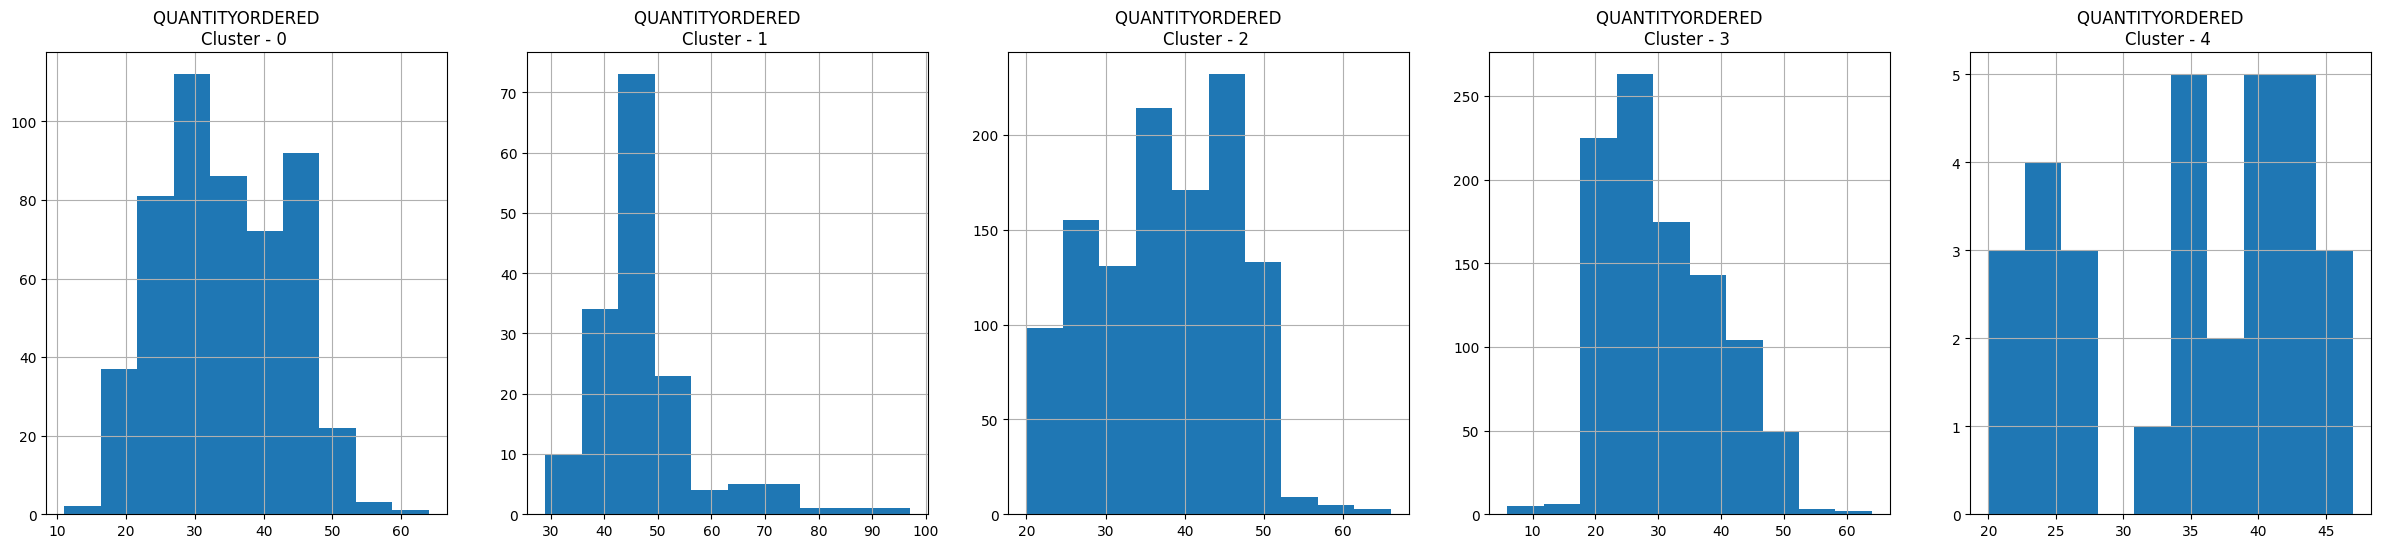

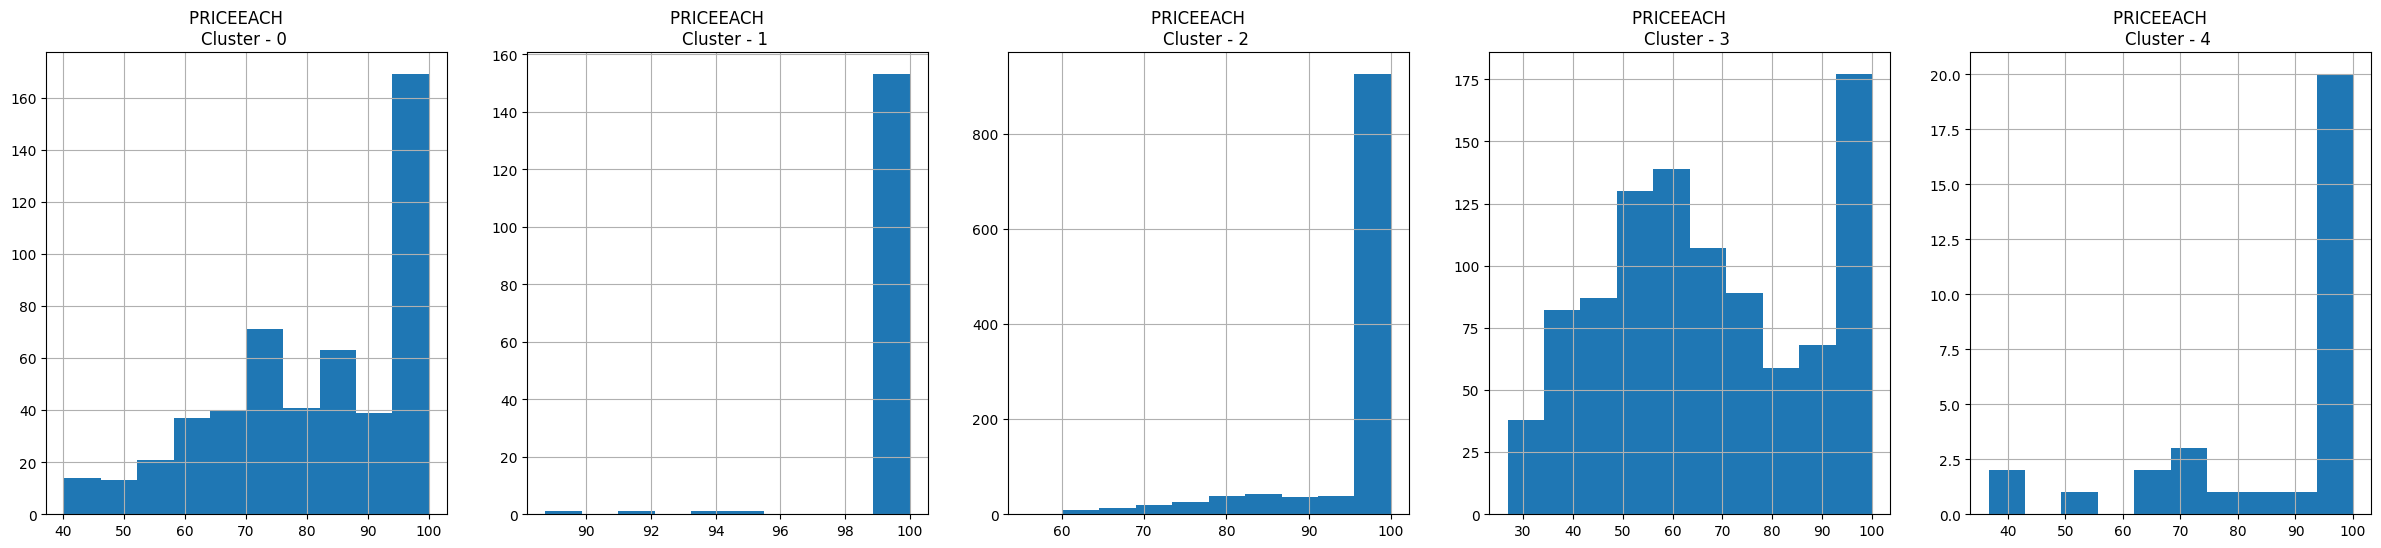

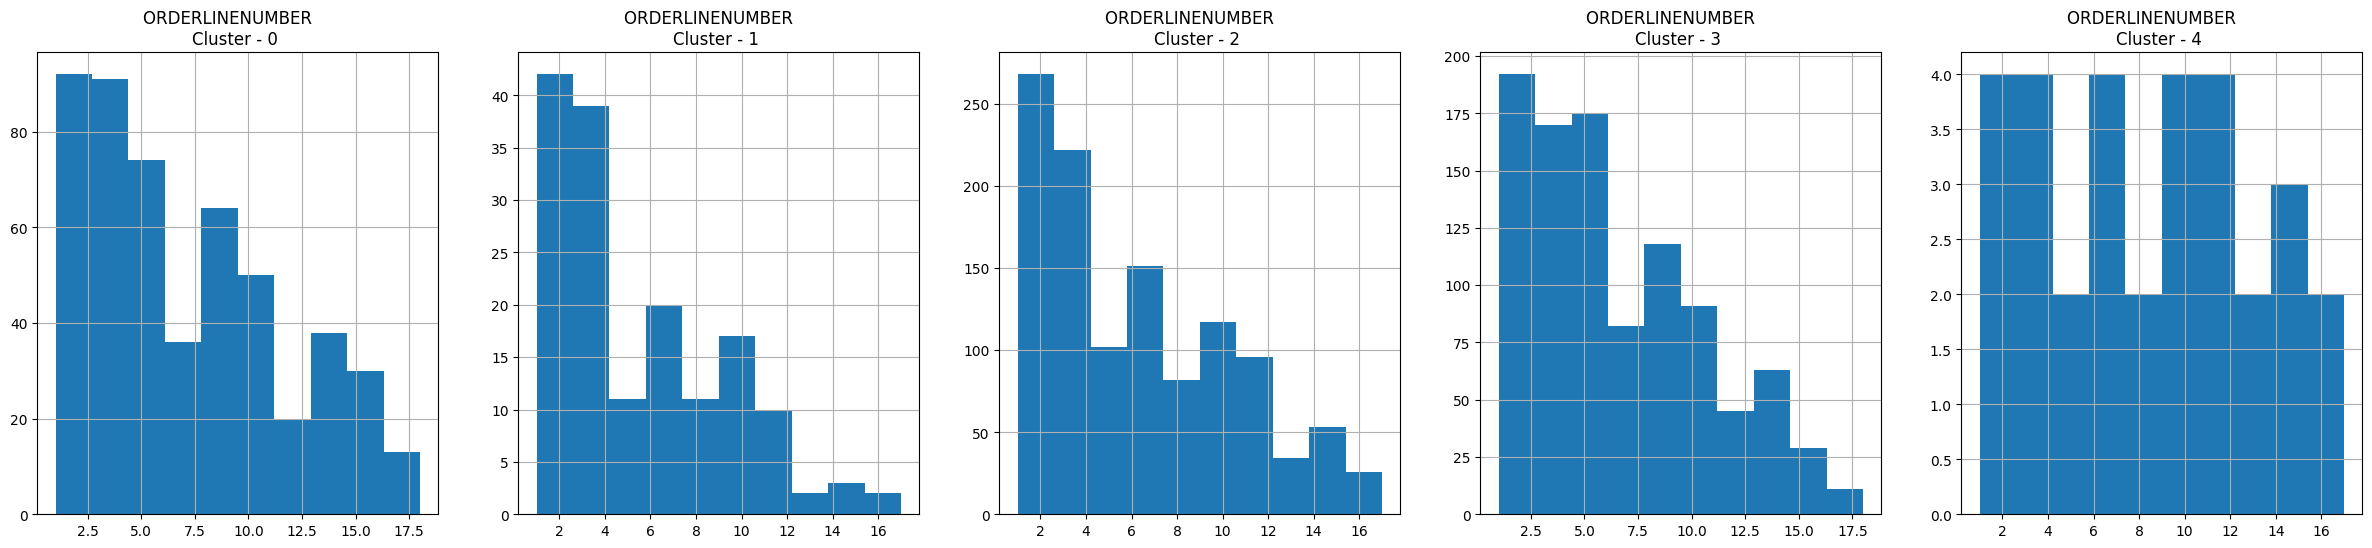

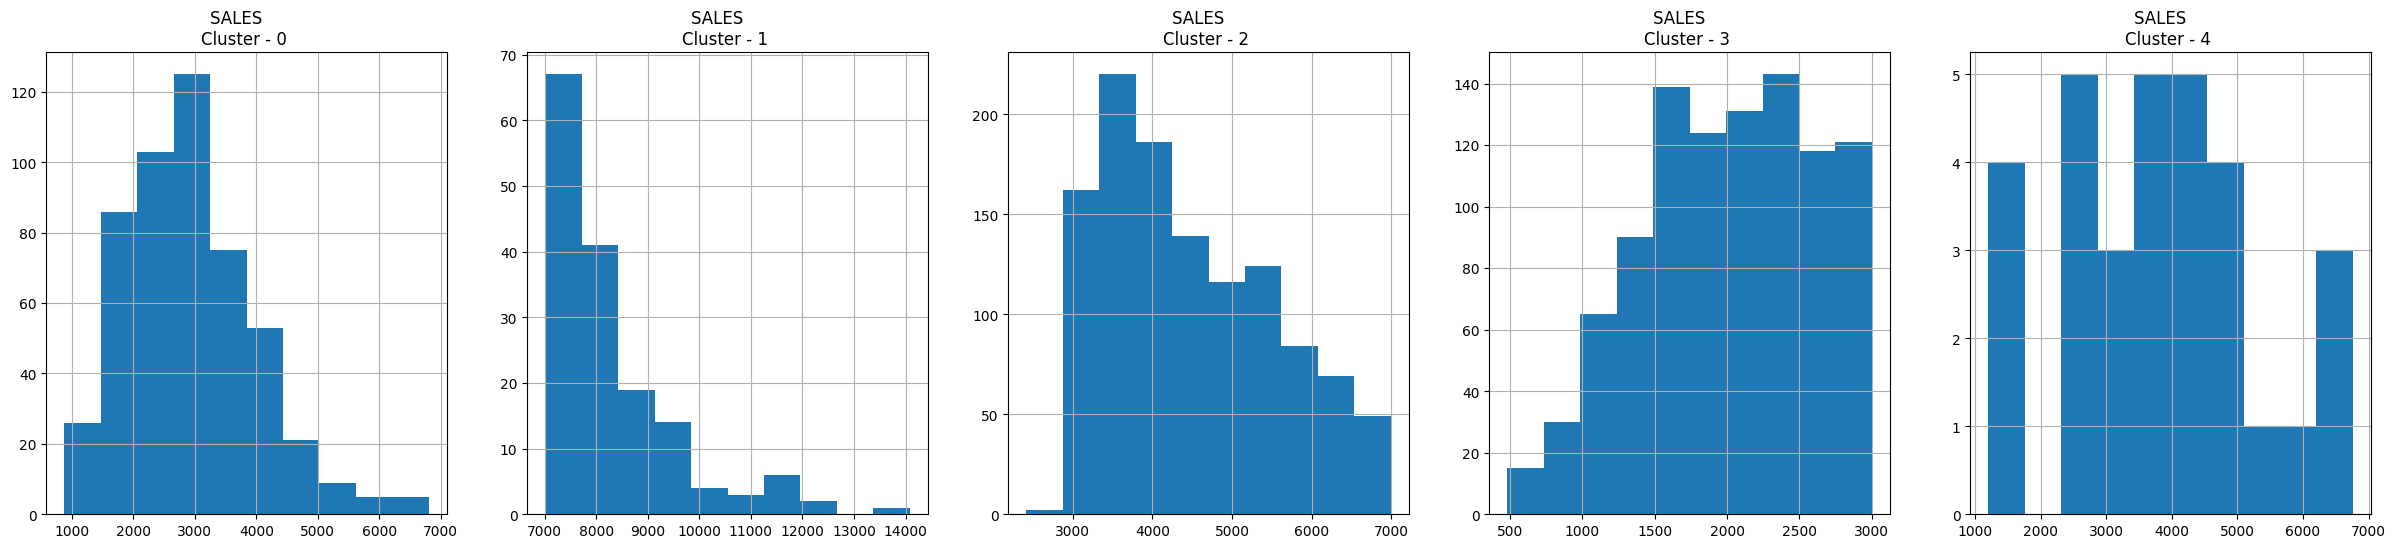

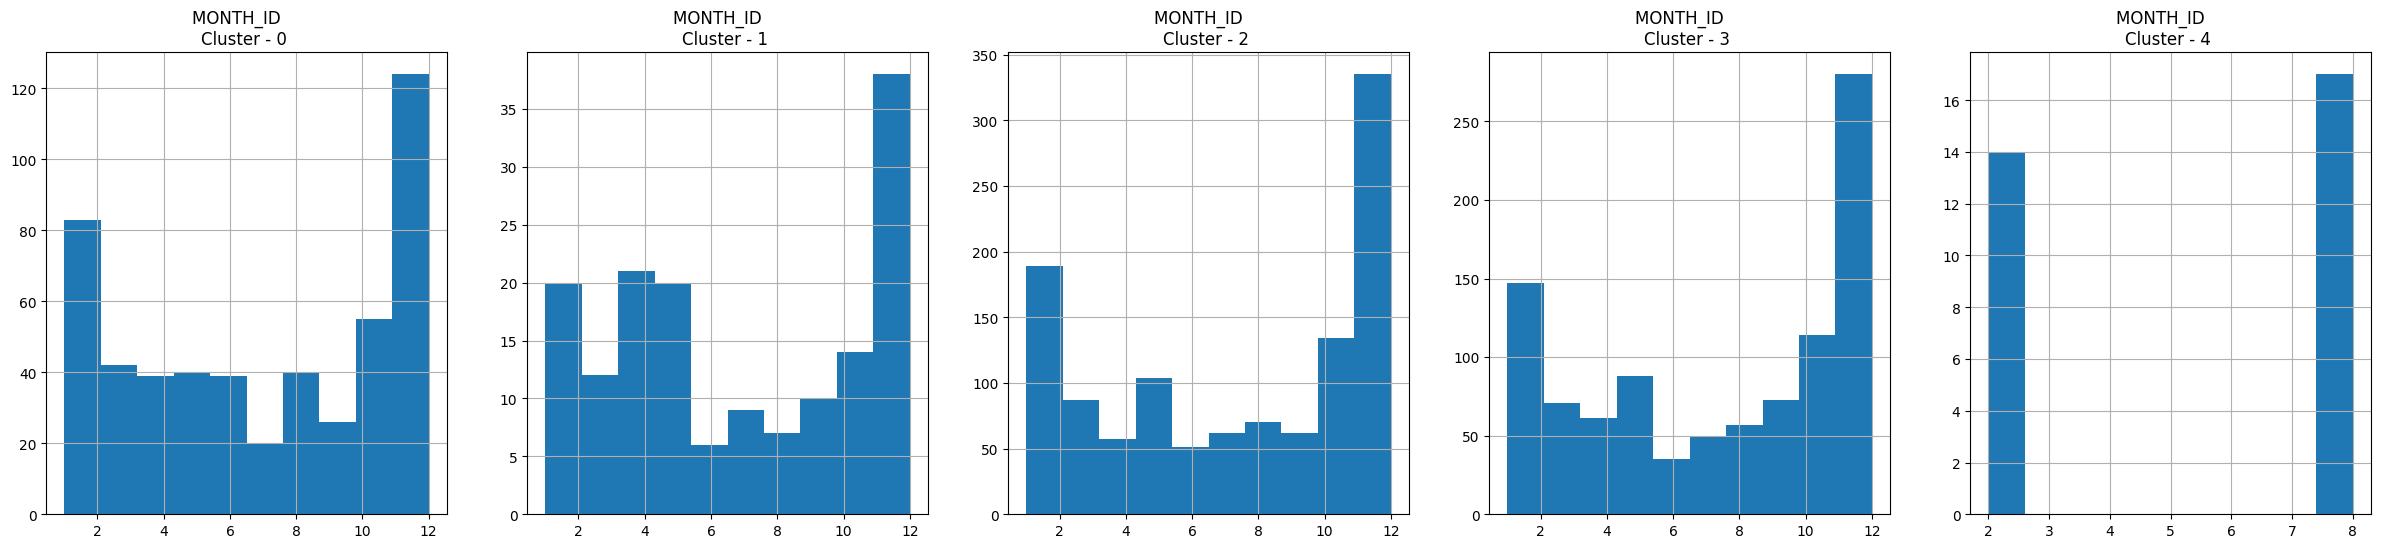

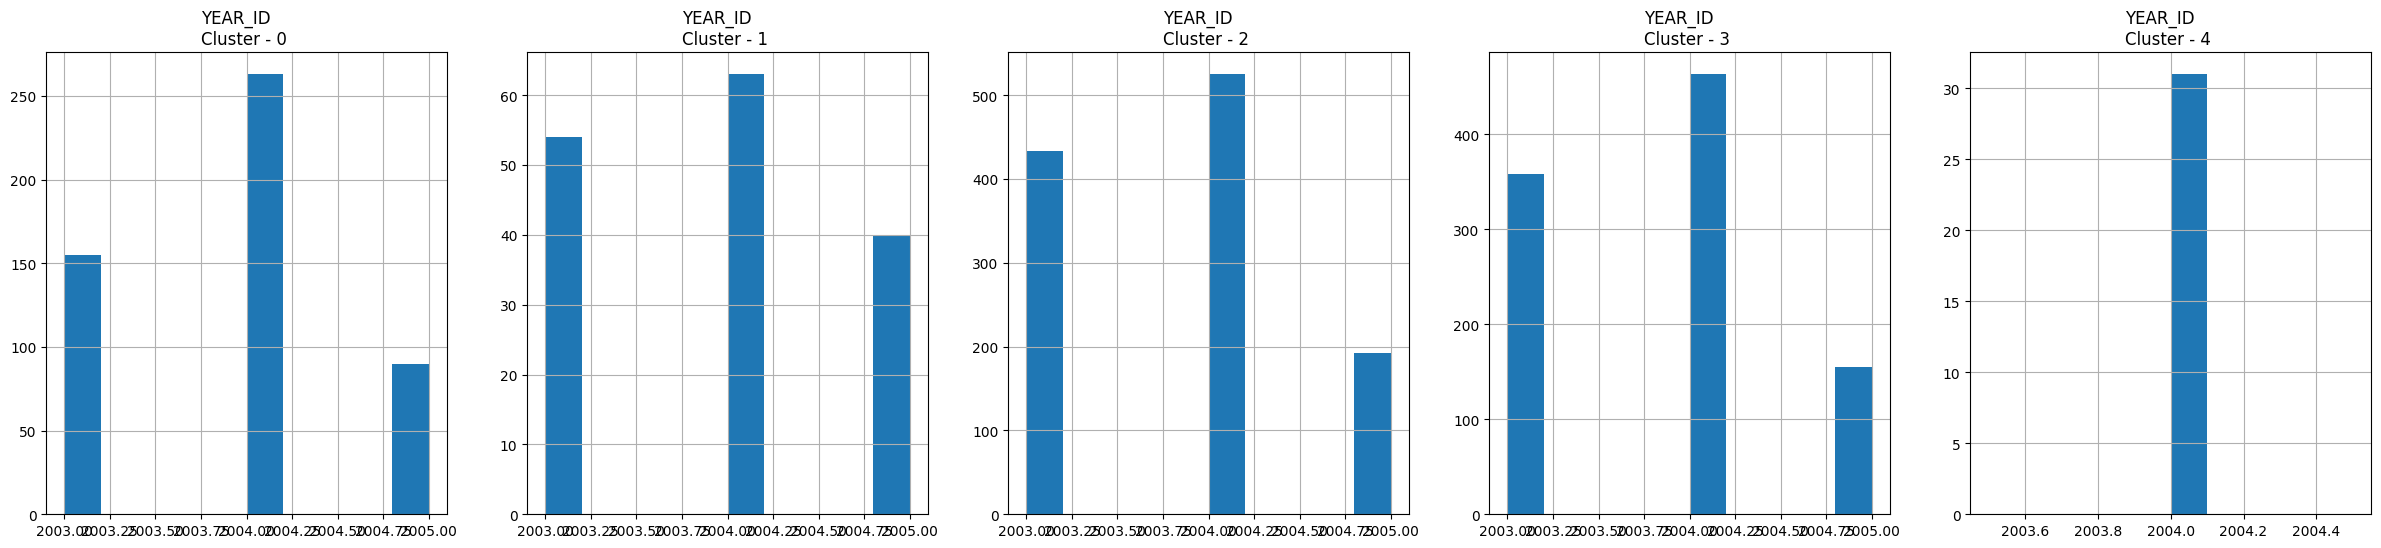

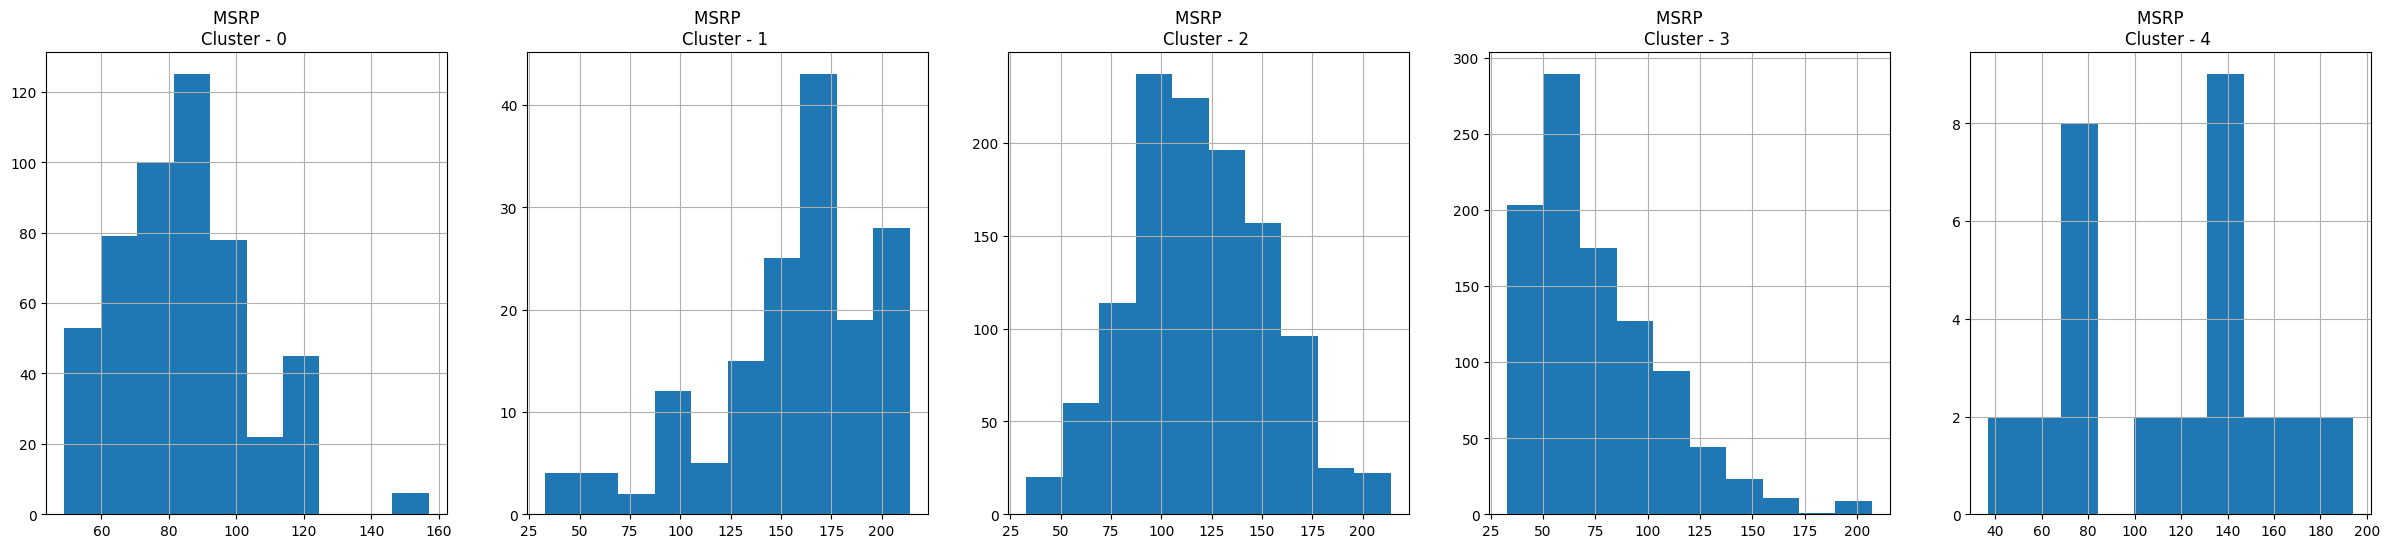

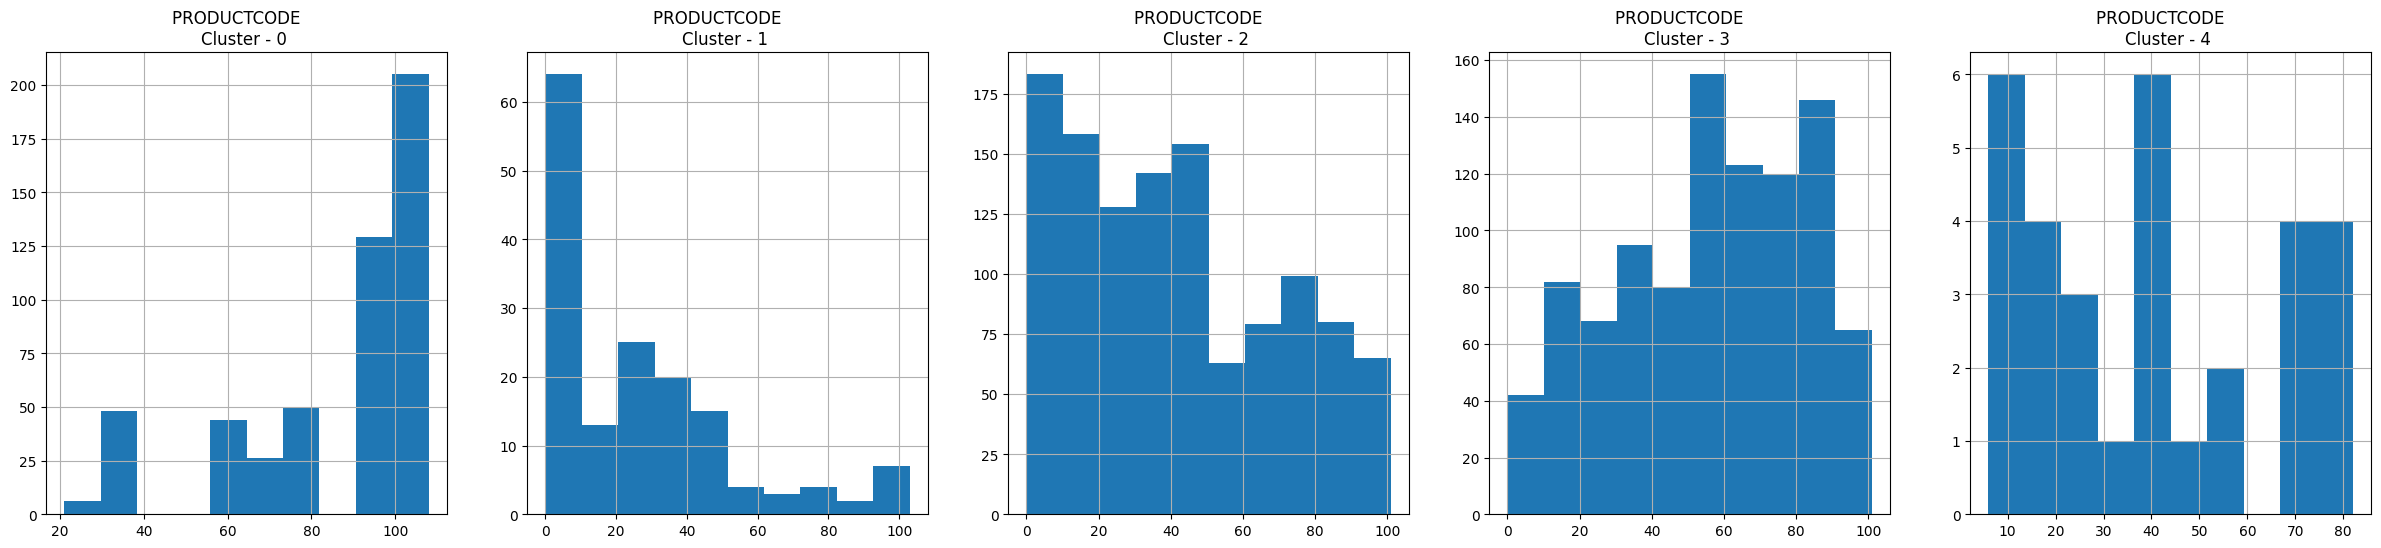

In [50]:
# plot histogram for each feature based on cluster
for i in sales_df.columns[:8]:
  plt.figure(figsize = (30, 6))
  for j in range(5):
    plt.subplot(1, 5, j+1)
    cluster = sale_df_cluster[sale_df_cluster['cluster'] == j]
    cluster[i].hist()
    plt.title('{}    \nCluster - {} '.format(i,j))

  plt.show()


In [51]:
# Reduce the original data to 3 dimensions using PCA for visualizig the clusters
pca = PCA(n_components = 3)
principal_comp = pca.fit_transform(sales_df_scaled)
principal_comp

array([[-0.4863427 , -1.21013347,  1.07761472],
       [-0.78467556, -1.0100581 ,  1.40896201],
       [ 1.43145311,  0.14212843,  0.28588836],
       ...,
       [ 0.38984017,  4.11425278,  0.03840211],
       [-2.78885651,  2.42151457,  1.47043626],
       [-0.705471  ,  3.31412333, -0.5254239 ]])

In [52]:
explained_variance = pca.explained_variance_ratio_


In [53]:
pca_df = pd.DataFrame(data = principal_comp, columns = ['pca1', 'pca2', 'pca2'])
pca_df.head()

,pca1,pca2,pca2
0,-0.486343,-1.210133,1.077615
1,-0.784676,-1.010058,1.408962
2,1.431453,0.142128,0.285888
3,1.288410,-0.228424,-0.505800
4,1.976008,-0.155375,-0.992640


In [54]:
# Concatenate the clusters labels to the dataframe
pca_df = pd.concat([pca_df, pd.DataFrame({'cluster':labels})], axis = 1)
pca_df

,pca1,pca2,pca2,cluster
0,-0.486343,-1.210133,1.077615,3
1,-0.784676,-1.010058,1.408962,3
2,1.431453,0.142128,0.285888,2
3,1.288410,-0.228424,-0.505800,2
4,1.976008,-0.155375,-0.992640,2
...,...,...,...,...
2818,-2.450337,1.089722,-1.399550,0
2819,-0.158231,3.628321,0.621604,0
2820,0.389840,4.114253,0.038402,0
2821,-2.788857,2.421515,1.470436,0


In [ ]:
# Visualize clusters using 3D-Scatterplot
fig = px.scatter_3d(pca_df, x = 'pca1', y = 'pca2', z = 'pca3',
              color='cluster', symbol = 'cluster', size_max = 10, opacity = 0.7)
fig.update_layout(margin = dict(l = 0, r = 0, b = 0, t = 0))